# Paper Figures: Two Schools, Strategic Student Test Taking 

Figure 8

Generates payoff matrices in terms of average admitted skill,
for test policy pairs of schools J1 and J2.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:

import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import os
import itertools
import json
import time

from multiprocessing import Pool

# Import our functions
from pipeline import pipeline
from visualization.two_school_strategic_plots import (filter_results_by_target_values, 
                                                      read_saved_inputs,
                                                      plot_avg_admitted_skill_by_policy,
                                                      plot_avg_admitted_skill_by_policy_heatmap)



In [33]:
simulation_name = "ms_revision_dec_2025_mult_schools_simulations_policy_testing"
fig_directory = os.path.join("visualization/", simulation_name)
output_root = os.path.join("simulation_data/", simulation_name)

print(fig_directory)
print(output_root)


if not os.path.exists(fig_directory):
    os.makedirs(fig_directory)
    
if not os.path.exists(output_root):
    os.makedirs(output_root)


visualization/ms_revision_dec_2025_mult_schools_simulations_policy_testing
simulation_data/ms_revision_dec_2025_mult_schools_simulations_policy_testing


# Running simulations for multiple instances

Run script 'run_two_school_cost_model.py'.

Runs all 4 policy combinations: SUB_SUB, SUB_FULL, FULL_SUB, FULL_FULL
For each parameter combination, all 4 policies share the same index.

Allows for parallel processing.

When running, set
* output_root
* n_processes
* base_parameters - in run_simulation()
* n_runs - in main block
* capacities, utilities, test_costs - in main block



In [34]:
feature_name_map = {-1:"SUB", 0:"FULL"}

# Read in simulation data

## Files per simulation run
For each index, the following files are saved:
- `students_df_{idx}.csv` - Student-level data (skills, features, decisions, admissions)
- `schools_df_{idx}.csv` - School-level metrics (e.g., `avgadmittedskill`)
- `parameters_of_interest_{idx}.json` - Key parameters: CAPACITY_a/b, UTILITY_a/b, STUDENT_TEST_COST
- `full_parameters_{idx}.json` - Complete simulation parameters

## Index structure
Indices follow the pattern: `idx = base_idx + run_num * 100`
- Same `base_idx` across policies = same parameter combination
- Example: indices 0, 100, 200, 300, 400 are 5 runs of the same parameter set

## Notes
1. **SUB_SUB is cost-invariant**: When both schools use SUB policy, `STUDENT_TEST_COST` has no effect (students never test). Filter SUB_SUB results separately when varying test cost.
2. **Policy naming**: Policy names include "_test" suffix (e.g., "SUB_SUB_test")
3. **Constraint**: Only combinations where `UTILITY_a > UTILITY_b` are valid (School 1 is more desirable)



In [35]:
policy_names = ["SUB_SUB_test", "SUB_FULL_test", "FULL_SUB_test", "FULL_FULL_test"]

num_buckets_qtilde_sub = 20

In [36]:

# Define the directory containing your files
directory = output_root

# Initialize a set to store unique indices
indices = set()

# List all files in the directory
folders = os.listdir(directory)

# Iterate over the files and extract indices
for folder in folders:
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
    for file in files:
        if file.startswith("full_parameters_") and file.endswith(".json"):
            index = int(file.split("_")[-1].split(".")[0])
            indices.add(index)
        elif file.startswith("students_df_") and file.endswith(".csv"):
            index = int(file.split("_")[-1].split(".")[0])
            indices.add(index)
        elif file.startswith("schools_df_") and file.endswith(".csv"):
            index = int(file.split("_")[-1].split(".")[0])
            indices.add(index)

In [37]:
print(folders), print(files), print(indices)

['SUB_FULL_test', 'FULL_FULL_test', 'FULL_SUB_test', 'SUB_SUB_test']
['parameters_of_interest_400.json', 'parameters_of_interest_103.json', 'students_df_104.csv', 'full_parameters_3.json', 'students_df_306.csv', 'students_df_0.csv', 'students_df_1.csv', 'students_df_307.csv', 'parameters_of_interest_206.json', 'students_df_105.csv', 'parameters_of_interest_302.json', 'full_parameters_400.json', 'students_df_107.csv', 'full_parameters_103.json', 'parameters_of_interest_2.json', 'students_df_305.csv', 'students_df_3.csv', 'students_df_2.csv', 'full_parameters_206.json', 'students_df_304.csv', 'students_df_106.csv', 'full_parameters_302.json', 'full_parameters_303.json', 'students_df_102.csv', 'students_df_300.csv', 'students_df_6.csv', 'full_parameters_207.json', 'students_df_7.csv', 'students_df_301.csv', 'full_parameters_102.json', 'parameters_of_interest_3.json', 'students_df_103.csv', 'full_parameters_401.json', 'parameters_of_interest_303.json', 'students_df_101.csv', 'students_df_3

(None, None, None)

In [38]:
from collections import defaultdict

parameters_of_interest_dicts = defaultdict(dict)
full_parameters_dicts = defaultdict(dict)
students_dfs = defaultdict(dict)
schools_dfs = defaultdict(dict)

for policy in policy_names:
    output_directory = os.path.join(output_root, policy)
    print(output_directory)
    for index in indices:
        try:
            parameters_of_interest, full_parameters, students_df, schools_df = read_saved_inputs(index, output_directory)
            
            binned_data, bins = pd.qcut(students_df["normal_learning_aware-1_score"], 
                                                    num_buckets_qtilde_sub, retbins=True, labels=False)


            # Map each row to the appropriate left edge
            #df["left_edge"] = df["bins"].map(lambda x: left_edges[x])
            
            students_df['qtilde_sub_cut'] = binned_data.map(lambda x: bins[x])
            
            parameters_of_interest_dicts[policy][index] = parameters_of_interest
            full_parameters_dicts[policy][index] = full_parameters
            students_dfs[policy][index] = students_df
            schools_dfs[policy][index] = schools_df
        except:
            print(f"No file found for index {index} in {policy}")
    

simulation_data/ms_revision_dec_2025_mult_schools_simulations_policy_testing/SUB_SUB_test
simulation_data/ms_revision_dec_2025_mult_schools_simulations_policy_testing/SUB_FULL_test
simulation_data/ms_revision_dec_2025_mult_schools_simulations_policy_testing/FULL_SUB_test
simulation_data/ms_revision_dec_2025_mult_schools_simulations_policy_testing/FULL_FULL_test


In [39]:
len(parameters_of_interest_dicts[policy])

40

In [40]:
len(students_dfs[policy])

40

In [41]:
results = []
# Iterate over each policy and index
for policy in policy_names:
    for index in indices:
        try:
            # Extract the DataFrame for the current policy and index
            df = schools_dfs[policy][index]
            
            # Get the average admitted skills for school a and b
            avg_skill_school_a = df.iloc[0]["avgadmittedskill"]
            avg_skill_school_b = df.iloc[1]["avgadmittedskill"]
            
            # Get the parameters for the current policy and index
            params = parameters_of_interest_dicts[policy][index]
            
            # Append the results to the list
            results.append({
                "Policy": policy,
                "Index": index,
                "avgadmittedskill_school_a": avg_skill_school_a,
                "avgadmittedskill_school_b": avg_skill_school_b,
                **params  # Unpack the parameters into the dictionary
            })
        except:
            print(f"No file found for index {index} in {policy}")
# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

results_df[['UTILITY_a', 'UTILITY_b']] = results_df['STUDENT_UTILITY'].apply(pd.Series)

results_df["STUDENT_TEST_COST"] = results_df["STUDENT_TEST_COST"].fillna(0)

In [42]:
results_df.head(10)

,Policy,Index,avgadmittedskill_school_a,avgadmittedskill_school_b,CAPACITY_a,CAPACITY_b,STUDENT_UTILITY,STUDENT_TEST_COST,UTILITY_a,UTILITY_b
0,SUB_SUB_test,0,0.748815,0.289108,0.2,0.2,"{'a': 3, 'b': 2}",0.50,3,2
1,SUB_SUB_test,1,0.791262,0.396327,0.2,0.2,"{'a': 3, 'b': 2}",1.50,3,2
2,SUB_SUB_test,2,0.837964,0.308064,0.2,0.2,"{'a': 3, 'b': 2}",1.75,3,2
3,SUB_SUB_test,3,0.793887,0.356203,0.2,0.2,"{'a': 3, 'b': 2}",2.00,3,2
4,SUB_SUB_test,4,0.856671,0.345886,0.2,0.2,"{'a': 4, 'b': 2}",0.50,4,2
5,SUB_SUB_test,5,0.782994,0.356555,0.2,0.2,"{'a': 4, 'b': 2}",1.50,4,2
6,SUB_SUB_test,6,0.851559,0.396979,0.2,0.2,"{'a': 4, 'b': 2}",1.75,4,2
7,SUB_SUB_test,7,0.946642,0.327797,0.2,0.2,"{'a': 4, 'b': 2}",2.00,4,2
8,SUB_SUB_test,400,0.733898,0.274279,0.2,0.2,"{'a': 3, 'b': 2}",0.50,3,2
9,SUB_SUB_test,401,0.935831,0.198088,0.2,0.2,"{'a': 3, 'b': 2}",1.50,3,2


In [50]:
(results_df
    .query("Policy == 'FULL_SUB_test'")
    .query("Index % 100 == 2")
    [["Index","avgadmittedskill_school_a", "avgadmittedskill_school_b"]])

,Index,avgadmittedskill_school_a,avgadmittedskill_school_b
82,2,0.384328,0.837964
90,402,0.411538,0.929371
98,302,0.368310,0.878868
106,202,0.265617,0.817216
114,102,0.427548,0.798781


In [51]:
std_all_indices = (results_df
        .query("Policy == 'FULL_SUB_test'")
        # .query("Index % 100 == 5")
        [["avgadmittedskill_school_a", "avgadmittedskill_school_b"]]
        .std()
        )
std_one_index = (results_df
        .query("Policy == 'FULL_SUB_test'")
        .query("Index % 100 == 2")
        [["avgadmittedskill_school_a", "avgadmittedskill_school_b"]]
        .std()
        )

print("Sanity check that instances are being run with correct indices:"+
      "\n std_all_indices should be greater than std_one_index")
print("std_all_indices: ", std_all_indices.values)
print("std_one_index: ", std_one_index.values)

Sanity check that instances are being run with correct indices:
 std_all_indices should be greater than std_one_index
std_all_indices:  [0.24021202 0.26888498]
std_one_index:  [0.06350245 0.05231243]


In [52]:
# Results for (SUB, SUB) policy pair
sub_sub_results = (results_df
                         .query("Policy == 'SUB_SUB_test'")[["Policy","UTILITY_a", "UTILITY_b", "avgadmittedskill_school_a", "avgadmittedskill_school_b", "CAPACITY_a", "CAPACITY_b", "STUDENT_TEST_COST"]]
                        )
sub_sub_results.head()

,Policy,UTILITY_a,UTILITY_b,avgadmittedskill_school_a,avgadmittedskill_school_b,CAPACITY_a,CAPACITY_b,STUDENT_TEST_COST
0,SUB_SUB_test,3,2,0.748815,0.289108,0.2,0.2,0.50
1,SUB_SUB_test,3,2,0.791262,0.396327,0.2,0.2,1.50
2,SUB_SUB_test,3,2,0.837964,0.308064,0.2,0.2,1.75
3,SUB_SUB_test,3,2,0.793887,0.356203,0.2,0.2,2.00
4,SUB_SUB_test,4,2,0.856671,0.345886,0.2,0.2,0.50


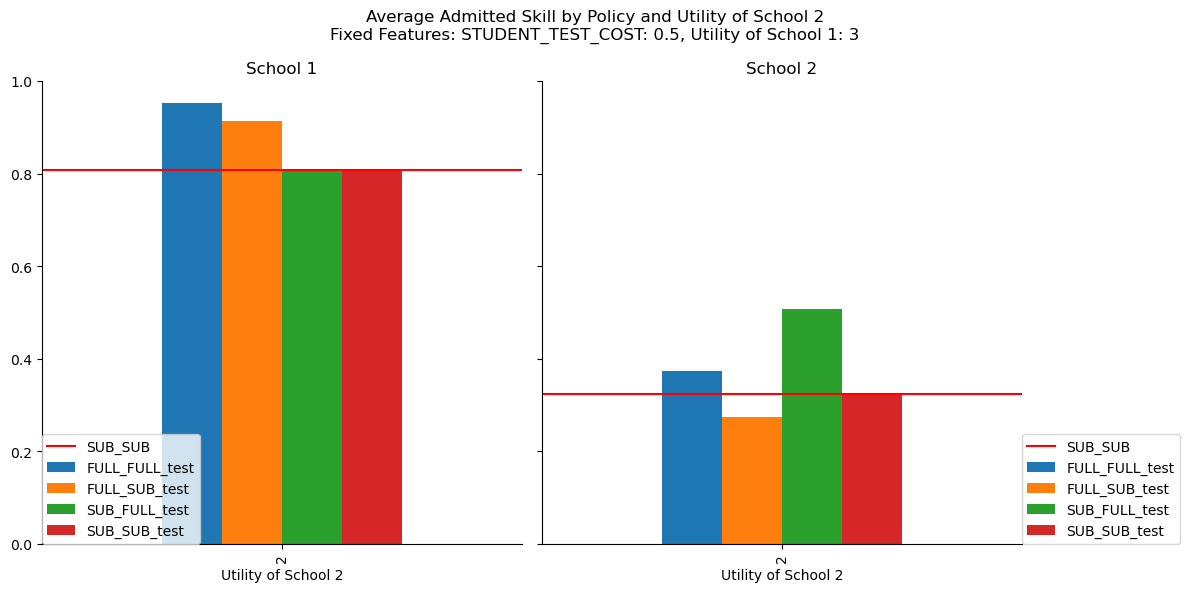

In [53]:
# Example usage
target_utility_a = results_df.UTILITY_a.unique()[0]
target_utility_b = results_df.UTILITY_b.unique()[0]
target_test_cost = np.sort(results_df.STUDENT_TEST_COST.unique())[0]
feature_to_vary = "UTILITY_b"

plot_avg_admitted_skill_by_policy(
    results_df=results_df,
    #sub_sub_results=sub_sub_results,
    feature_to_vary=feature_to_vary,
    target_values={#'UTILITY_b': target_utility_b, 
                   'STUDENT_TEST_COST': target_test_cost,
                   'UTILITY_a': target_utility_a,
                   },
)

# Heatmap visualizations of payoff matrix - Main Text

### With utilities (3,2) for $J_1, J_2$ and test cost=2.

With only mean values

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


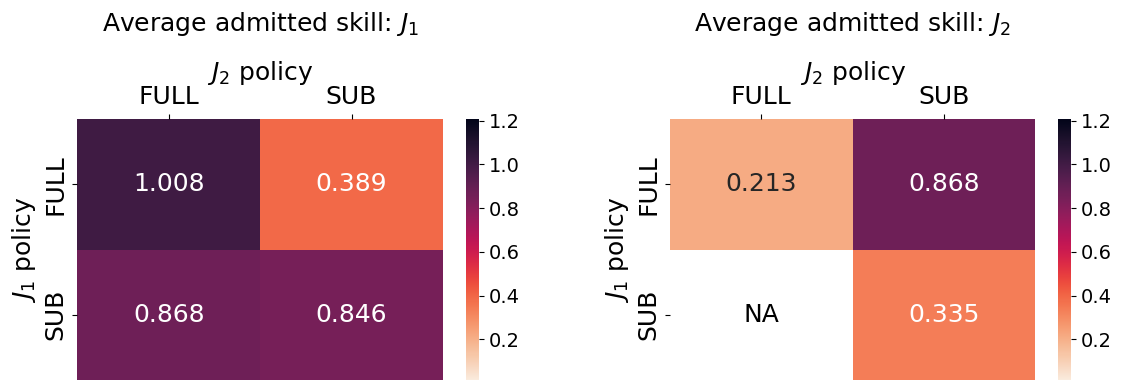

In [54]:
target_utility_a = 3
target_utility_b = 2
target_test_cost = 2

target_values = {'UTILITY_b': target_utility_b, 
                'STUDENT_TEST_COST': target_test_cost,
                'UTILITY_a': target_utility_a,
                }



plot_avg_admitted_skill_by_policy_heatmap(results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values=target_values,
                                            fig_directory=fig_directory,
                                            plot_standard_errors=False,
                                            )

With mean and 2* SEs

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


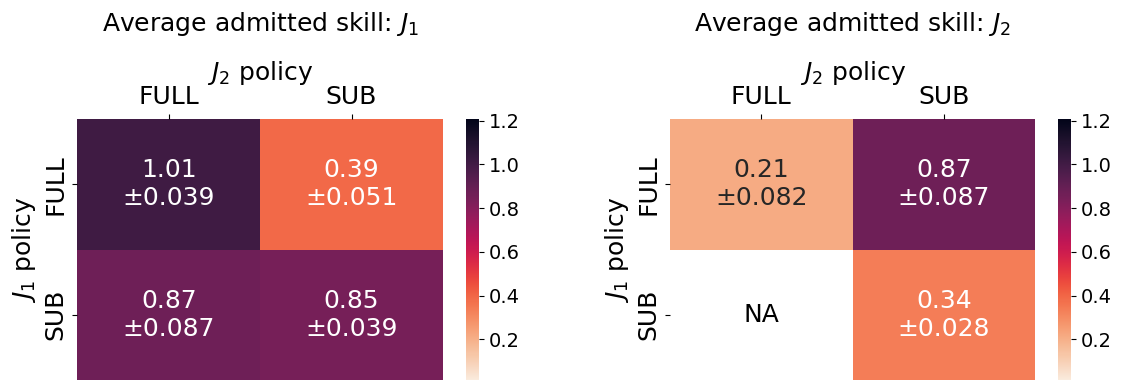

In [56]:
target_utility_a = 3
target_utility_b = 2
target_test_cost = 2

target_values = {'UTILITY_b': target_utility_b, 
                'STUDENT_TEST_COST': target_test_cost,
                'UTILITY_a': target_utility_a,
                }



plot_avg_admitted_skill_by_policy_heatmap(results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values=target_values,
                                            fig_directory=fig_directory,
                                            plot_standard_errors=True,
                                            )

### Plot with utility_a = 3, utility_b = 2, test_cost = 0.5

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


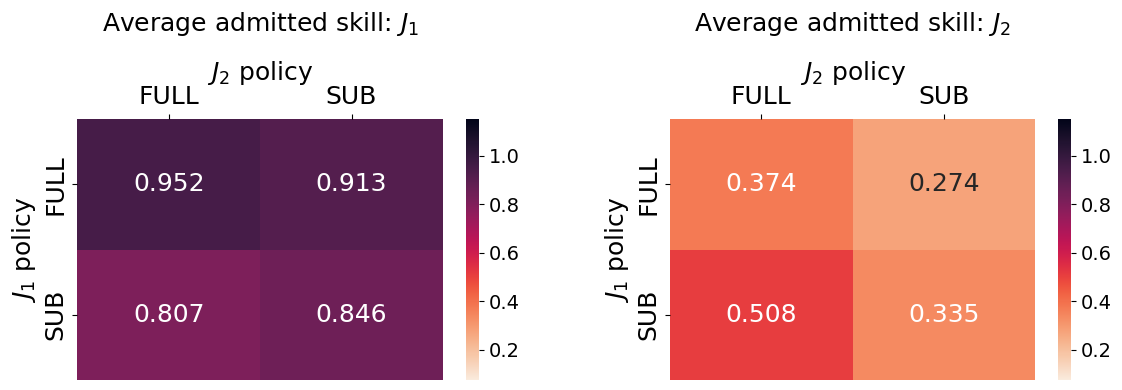

In [57]:

target_utility_a = 3
target_utility_b = 2
target_test_cost = 0.5

target_values = {'UTILITY_b': target_utility_b, 
                'STUDENT_TEST_COST': target_test_cost,
                'UTILITY_a': target_utility_a,
                }

plot_avg_admitted_skill_by_policy_heatmap(results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values=target_values,
                                            fig_directory=fig_directory,
                                            )



/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


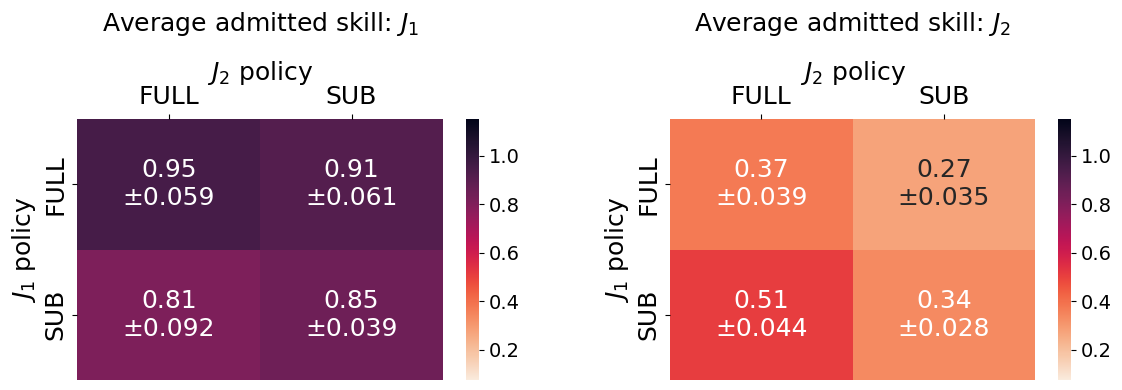

In [58]:
plot_avg_admitted_skill_by_policy_heatmap(results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values=target_values,
                                            fig_directory=fig_directory,
                                            plot_standard_errors=True,
                                            )

# Heatmap visualizations - Appendix figures


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


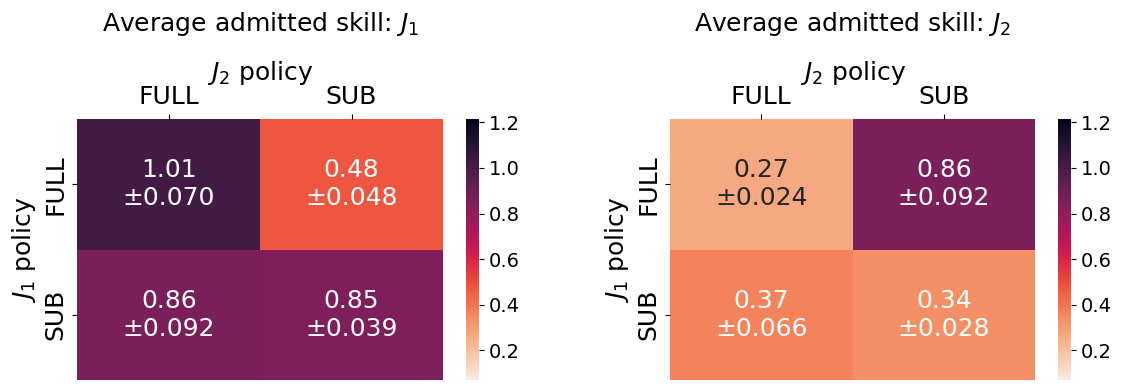

In [59]:
target_utility_a = 3
target_utility_b = 2
target_test_cost = 1.5

target_values = {'UTILITY_b': target_utility_b, 
                'STUDENT_TEST_COST': target_test_cost,
                'UTILITY_a': target_utility_a,
                }

plot_avg_admitted_skill_by_policy_heatmap(results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values=target_values,
                                            fig_directory=fig_directory,
                                            plot_standard_errors=True,
                                            )

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


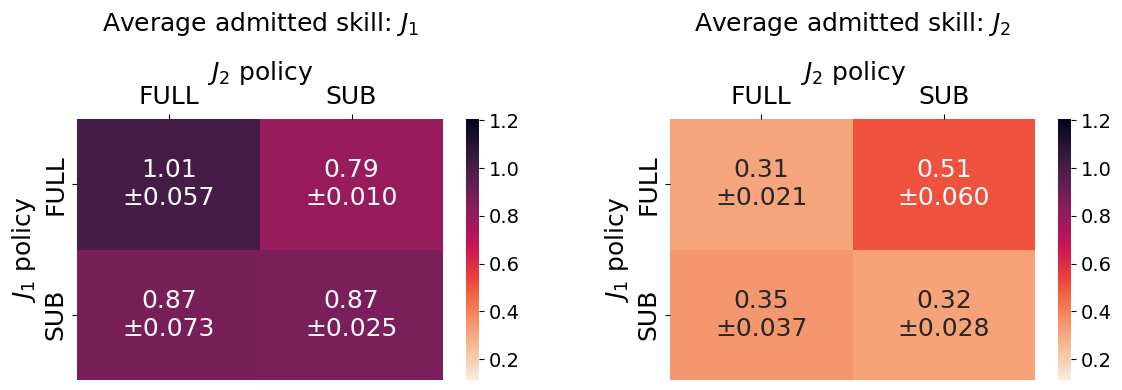

In [60]:
target_utility_a = 4
target_utility_b = 2
target_test_cost = 1.5

target_values = {'UTILITY_b': target_utility_b, 
                'STUDENT_TEST_COST': target_test_cost,
                'UTILITY_a': target_utility_a,
                }

plot_avg_admitted_skill_by_policy_heatmap(results_df=results_df,
                                            sub_sub_results=sub_sub_results,
                                            feature_to_vary=None,
                                            target_values=target_values,
                                            fig_directory=fig_directory,
                                            plot_standard_errors=True,
                                            )